c:\Users\kurag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 198s 58ms/step - accuracy: 0.5258 - loss: 0.6892 - val_accuracy: 0.7443 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 2/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 189s 56ms/step - accuracy: 0.7873 - loss: 0.4826 - val_accuracy: 0.8612 - val_loss: 0.3601 - learning_rate: 0.0010
Epoch 3/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 193s 57ms/step - accuracy: 0.8711 - loss: 0.3538 - val_accuracy: 0.8864 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 4/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 196s 58ms/step - accuracy: 0.8949 - loss: 0.3087 - val_accuracy: 0.8971 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 5/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 197s 59ms/step - accuracy: 0.9094 - loss: 0.2815 - val_accuracy: 0.9023 - val_loss: 0.2947 - learning_rate: 0.0010
Epoch 6/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 197s 59ms/step - accuracy: 0.9171 - loss: 0.2655 - val_accuracy: 0.8972 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 7/20
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 199s 59ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    31,245,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,752,209 (121.13 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 31,245,900 (119.19 MB)

 Optimizer params: 337,540 (1.29 MB)

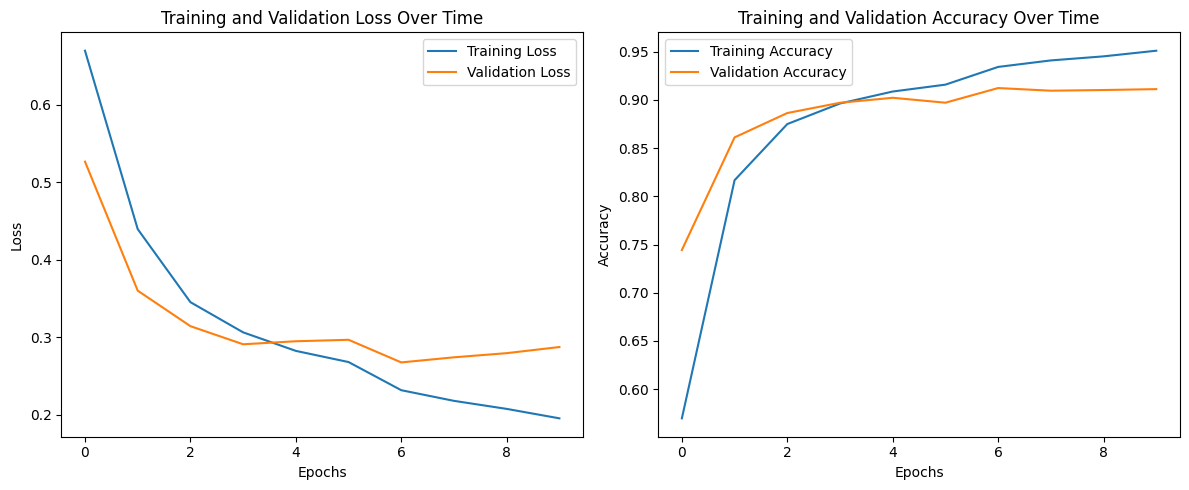

In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Features_For_Traditional_ML_Techniques.csv')

df = df.drop(columns=['statement', 'BinaryNumTarget'])

# Extract the tweet text and labels
tweets = df['tweet'].astype(str).values
labels = df['majority_target'].values

# Pre-train Word2Vec model
sentences = [tweet.split() for tweet in tweets]  # Tokenize the tweets for Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Extract the vocabulary and word vectors
word_vectors = word2vec_model.wv
vocab_size = len(word_vectors)
embedding_dim = word_vectors.vector_size

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))  # +1 for padding token

# Populate the embedding matrix with the Word2Vec vectors
for i, word in enumerate(word_vectors.index_to_key):
    embedding_matrix[i + 1] = word_vectors[word]  # i+1 because index 0 is reserved for padding

# Tokenize and convert the tweets to sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

# Pad the sequences to ensure they are of the same length
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Modify the model to add more complexity
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),  # Use pre-trained Word2Vec embeddings, freeze the layer
    LSTM(128, return_sequences=True),  # Increased units
    Dropout(0.5),  # Keep Dropout
    LSTM(64, return_sequences=False),  # Added another LSTM layer
    Dropout(0.5),  # Keep Dropout
    Dense(32, activation='relu'),  # L2 Regularization
    Dropout(0.5),  # Additional Dropout
    Dense(1, activation='sigmoid')  # Binary classification
])

# Implement Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Compile and fit with increased epochs
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased number of epochs
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]  # Use the same callbacks
)

# Display the model summary
model.summary()

# Extract training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the training and validation loss over epochs
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()
